In [1]:
import numpy, random, math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import random

In [2]:
numpy.random.seed(100)

classA = numpy.concatenate((
    numpy.random.randn(10, 2) * 0.3 + [1.5, 0.5],
    numpy.random.randn(5, 2) * 0.3 + [-1.5, 0.5],
    numpy.random.randn(5, 2) * 0.7 + [0.0, -1.0],
    ))
classB=numpy.random.randn(20, 2) * 0.3 + [0.0, -0.5]

inputs=numpy.concatenate((classA, classB))
targets=numpy.concatenate((numpy.ones(classA.shape[0]), -numpy.ones(classB.shape[0])))

N = inputs.shape[0] # Number of rows (samples)

permute = list(range(N))
random.shuffle(permute)
inputs = inputs[permute,:]
targets = targets[permute]

In [3]:
#Linear kernel
def LinearKernel(x, y):
    # Todo: Transform x
    return numpy.dot(x, y)
    
# Polynomial kernels
def PolyKernel(x, y):
    # Todo: Transform x
    # The exponent p (a positive integer) controls the degree of the polynomials. 
    # p = 2 will make quadratic shapes (ellipses, parabolas, hyperbolas). 
    # Setting p = 3 or higher will result in more complex shapes.
    p = 5
    return numpy.power(numpy.dot(x, y) + 1, p)
    
def RBFKernel(x, y):
    # the parameter sigma is used to control the smoothness of the boundary
    sigma = 2
    return math.exp(-math.pow(numpy.linalg.norm(numpy.subtract(x, y)), 2)/(2 * math.pow(sigma,2)))

Kernel = RBFKernel

In [4]:
Pmatrix = numpy.zeros((N,N))
for i in range(N):
    for j in range(N):
        Pmatrix[i][j] = targets[i] * targets[j] * Kernel(inputs[i], inputs[j])

In [5]:
def zerofun(alpha):
    return numpy.dot(alpha, targets)

In [6]:
def objective(alpha):
    return (1/2)*numpy.dot(alpha, numpy.dot(alpha, Pmatrix)) - numpy.sum(alpha)

In [32]:
start = numpy.zeros(N) # N is the number of training samples
C = 10000

# To have an upper constraint
B = [(0, C) for b in range(N)]

# To only have a lower bound:
# B = [(0, None) for b in range(N)]

# XC is the second half of equation 10; given as a dictionary with fields type and fun
# In the following example, zerofun is a function which calculates the value which
# ...should be constrained to zero.
XC = {'type':'eq', 'fun':zerofun}

ret = minimize(objective, start, bounds=B, constraints=XC)
if (not ret['success']): # The string 'success' instead holds a boolean representing if the optimizer has found a solution
    raise ValueError('Cannot find optimizing solution')

# Extract non-zero alphas
alpha = ret['x']
nonzero = [(alpha[i], inputs[i], targets[i]) for i in range(N) if abs(alpha[i]) > 10e-5]

ValueError: Cannot find optimizing solution

In [33]:
def bval():
    bsum = 0
    for value in nonzero:
        bsum += value[0] * value[2] * Kernel(value[1], nonzero[0][1])
    return bsum - nonzero[0][2]
        
def indicator(x, y, b):
    totsum = 0
    for value in nonzero:
        totsum += value[0] * value[2] * Kernel([x, y], value[1])
    return totsum - b

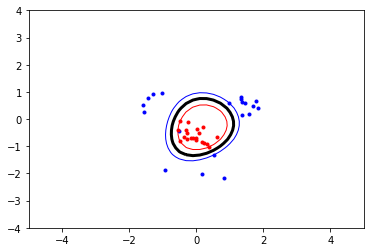

In [35]:
b = bval()

# Plot data points
plt.plot([p[0] for p in classA], [p[1] for p in classA], 'b.')
plt.plot([p[0] for p in classB], [p[1] for p in classB], 'r.')
#plt.plot([p[1][0] for p in nonzero], [p[1][1] for p in nonzero], 'yo')

# Plot contour
xbound = 5
ybound = 4
xgrid = numpy.linspace(-xbound, xbound)
ygrid = numpy.linspace(-ybound, ybound)
grid = numpy.array([[indicator(x, y, b) for x in xgrid] for y in ygrid])
plt.contour(xgrid, ygrid, grid, (-1.0,0.0,1.0), colors=('red','black','blue'), linewidths=(1,3,1))

#plt.savefig('svmplot.pdf') # Save a copy in a file
plt.show() # Show the plot on the screen